# Временные ряды

В данном jupyter notebook мы начнем погружение в мир автоматического машинного обучения для задач на временных рядах.

Однако чтобы хорошо разобраться в автоматическом инструментарии, сначала необходимо понять какие операции над временными рядами делают, и какие задачи это помогает решать

## Определение 

Временной ряд — это набор наблюдений, упорядоченных во времени

Так давайте посмотрим на то какие они бывают!

<img src="../data/all_simple_synthetic_dataset_for_learning.png" alt="Time series dataset" width="500">



In [55]:
import numpy as np
import pandas  as pd
from pathlib import Path

import matplotlib.pyplot as plt

np.random.seed(42)

Поскольку, это набор, упорядоченных по времени, сгенерируем временную шкалу на 100 обьектов

In [56]:
start: str = "2025-01-01"
freq: str = "D"
n: int = 100

datetime_index = pd.date_range(start=start, periods=n, freq=freq)

А теперь сгенерируем временной ряд где каждый последующий элемент случаен

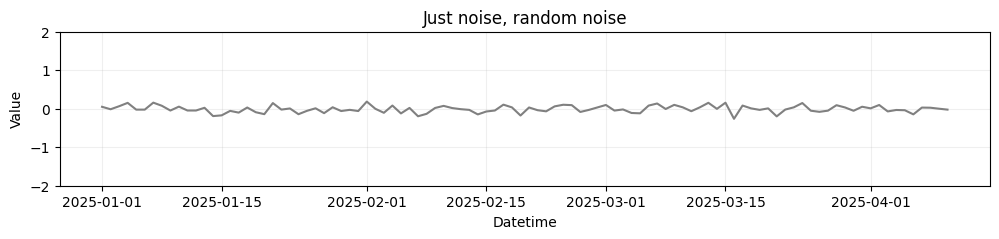

In [57]:
noise_component_max = 0.1
noise_values = np.random.normal(0, noise_component_max, n)

fig_size = (12.0, 2.0)
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(datetime_index, noise_values, c="grey")
ax.grid(alpha=0.2)
ax.set_xlabel("Datetime")
ax.set_ylabel("Value")
ax.set_ylim(-2, 2)
ax.set_title("Just noise, random noise")
plt.show()

Такой "временной ряд" состоит из шума и только 

Но есть и более интересные варианты. Например, ряд, в котором помимо шума есть сезонная компонента

## Сезонность

> Сезонная компонента во временном ряду - это часть изменений,
которая повторяется с постоянной периодичностью во времени
(например, раз в сутки, раз в неделю, раз в год)

© Box, G. E. P., Jenkins, G. M., Reinsel, G. C., & Ljung, G. M. (2016). Time Series Analysis: Forecasting and Control (5th ed.). Wiley. глава 2.3 "The Components of a Time Series", стр. 36–38

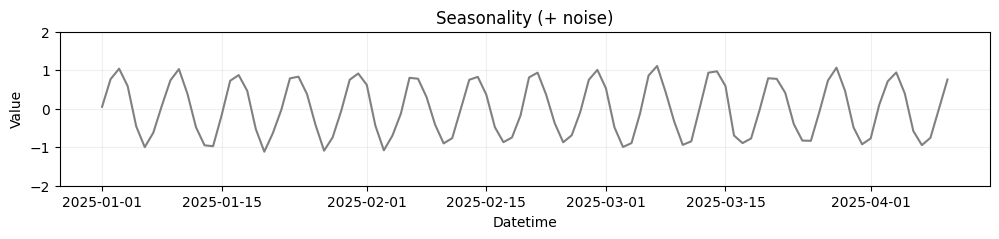

In [58]:
t = np.arange(n)
# Let's simulate week seasonality
m = 7
values = np.sin(2 * np.pi * t / m) + noise_values

fig_size = (12.0, 2.0)
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(datetime_index, values, c="grey")
ax.grid(alpha=0.2)
ax.set_xlabel("Datetime")
ax.set_ylabel("Value")
ax.set_ylim(-2, 2)
ax.set_title("Seasonality (+ noise)")
plt.show()

## Циклы

> Циклическая компонента (или циклы) во временном ряду -
это часть колебаний, отражающая долгосрочные волнообразные изменения вокруг тренда,
которые не имеют фиксированной длины периода

© Box, G. E. P., Jenkins, G. M., Reinsel, G. C., & Ljung, G. M. (2016).
Time Series Analysis: Forecasting and Control (5th ed.).
Wiley. глава 2.3 “The Components of a Time Series”, стр. 37–39.

© Chatfield, C. (2003). The Analysis of Time Series: An Introduction (6th ed.).
Chapman & Hall/CRC, глава 1.3 “Trend, Seasonal and Cyclical Variation”.

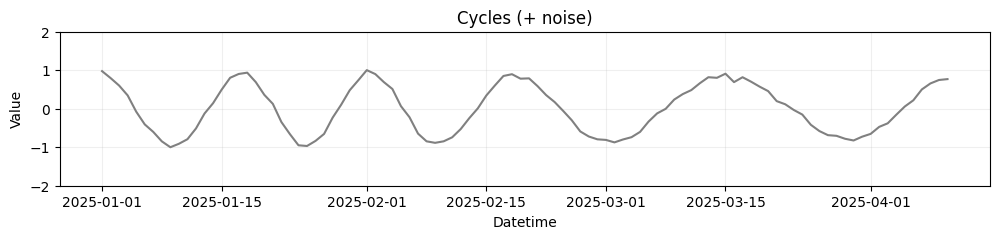

In [59]:
# Generating cycles
freq_base = 1 / 20
freq_variation = 1 / 60 * np.sin(2 * np.pi * t / n)
instantaneous_freq = freq_base + freq_variation
phase = 2 * np.pi * np.cumsum(instantaneous_freq)
values = np.cos(phase) * np.exp(-t / 400) + noise_values * 0.5

fig_size = (12.0, 2.0)
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(datetime_index, values, c="grey")
ax.grid(alpha=0.2)
ax.set_xlabel("Datetime")
ax.set_ylabel("Value")
ax.set_ylim(-2, 2)
ax.set_title("Cycles (+ noise)")
plt.show()

## Тренд

> Тренд во временном ряду - это долгосрочная, устойчиво направленная компонента,
отражающая общую тенденцию изменения уровня ряда во времени
(например, рост, спад или стабильность),
не зависящую от краткосрочных колебаний и случайных флуктуаций.

© Box, G. E. P., Jenkins, G. M., Reinsel, G. C., & Ljung, G. M. (2016). Time Series Analysis: Forecasting and Control (5th ed.). Wiley. глава 2.3 "The Components of a Time Series", стр. 36–38

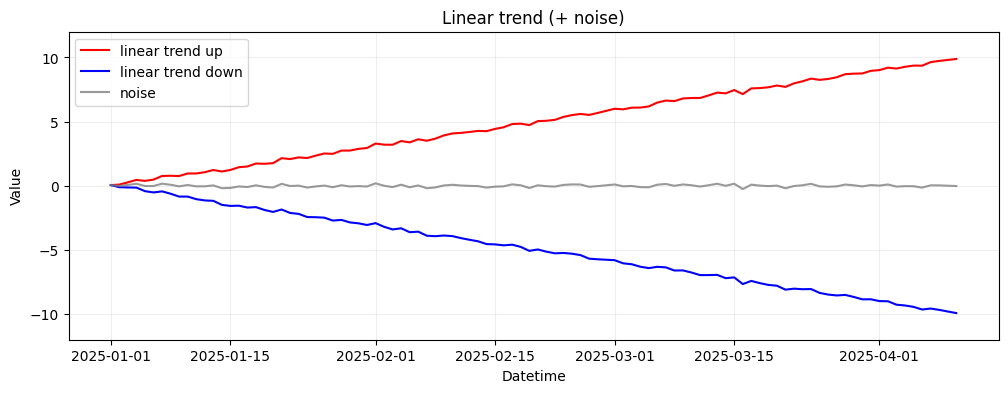

In [60]:
values_up = 0.1 * t + noise_values
values_down = -0.1 * t + noise_values

fig_size = (12.0, 4.0)
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(datetime_index, values_up, c="red", label="linear trend up")
ax.plot(datetime_index, values_down, c="blue", label="linear trend down")
ax.plot(datetime_index, noise_values, c="grey", alpha=0.8, label="noise")
ax.grid(alpha=0.2)
ax.legend()
ax.set_xlabel("Datetime")
ax.set_ylabel("Value")
ax.set_ylim(-12, 12)
ax.set_title("Linear trend (+ noise)")
plt.show()

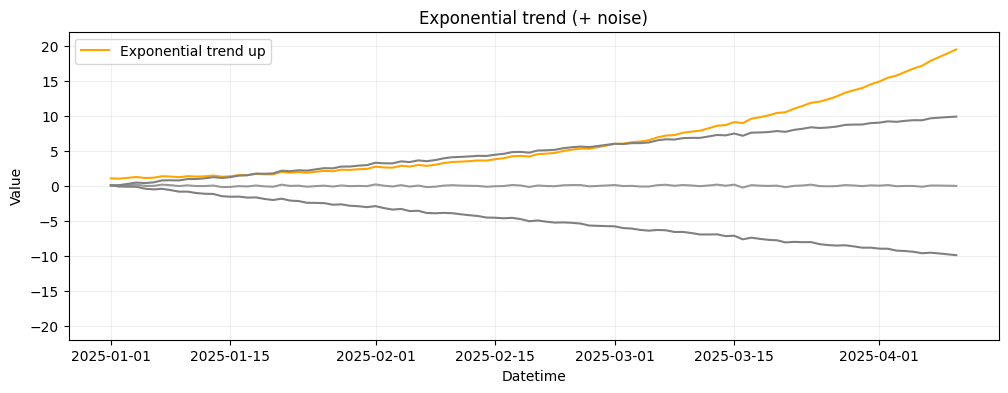

In [61]:
values = np.exp(0.03 * t) + noise_values

fig_size = (12.0, 4.0)
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(datetime_index, values, c="orange", label="Exponential trend up")
ax.plot(datetime_index, values_up, c="grey")
ax.plot(datetime_index, values_down, c="grey")
ax.plot(datetime_index, noise_values, c="grey", alpha=0.8)
ax.grid(alpha=0.2)
ax.legend()
ax.set_xlabel("Datetime")
ax.set_ylabel("Value")
ax.set_ylim(-22, 22)
ax.set_title("Exponential trend (+ noise)")
plt.show()

## Структурные сдвиги*

*эта категория может быть частным случаем тренда, сезонности или других нестационарностей во временном ряду.

> Структурный сдвиг во временном ряду —
это внезапное изменение статистических свойств ряда
(например, среднего уровня, дисперсии или характера зависимости между наблюдениями),
происходящее в определённый момент времени
вследствие изменения внешних условий или внутренних характеристик исследуемого процесса.

© Gujarati, D. N., & Porter, D. C. (2009).
Basic Econometrics (5th ed.). McGraw-Hill, глава 12:
Structural Change and Dummy Variables.

© Hamilton, J. D. (1994). Time Series Analysis. Princeton University Press — раздел 22.1 Structural Breaks.

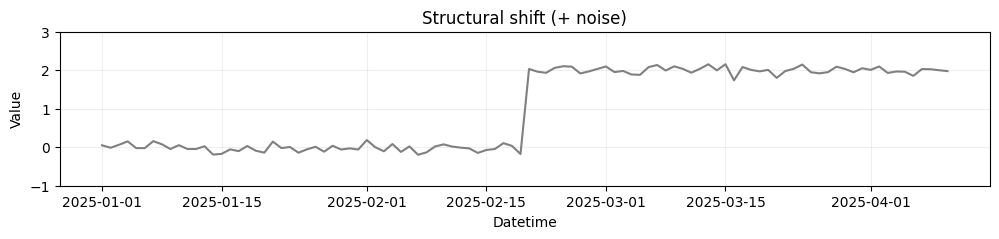

In [63]:
shift_point = n // 2
values = noise_values.copy()
values[shift_point:] += 2.0

fig_size = (12.0, 2.0)
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(datetime_index, values, c="grey")
ax.grid(alpha=0.2)
ax.set_xlabel("Datetime")
ax.set_ylabel("Value")
ax.set_ylim(-1, 3)
ax.set_title("Structural shift (+ noise)")
plt.show()

## Изменение в дисперсии

Изменение дисперсии (change in variance) означает, что разброс значений временного ряда во времени непостоянен

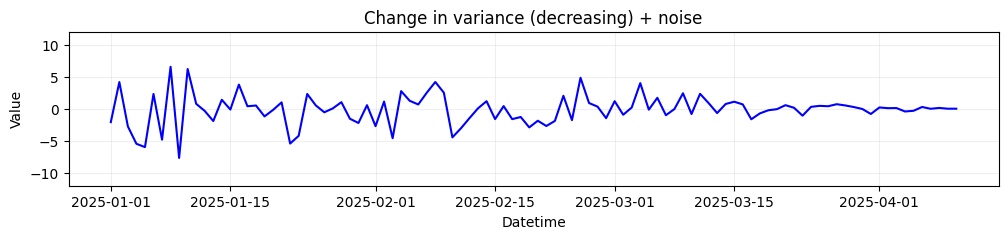

In [75]:
eps = np.random.normal(0, 2, n)
std_schedule = np.linspace(20, 0.5, n)
values = (0.1 * std_schedule) * eps

fig_size = (12.0, 2.0)
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(datetime_index, values, c="blue")
ax.grid(alpha=0.2)
ax.set_xlabel("Datetime")
ax.set_ylabel("Value")
ax.set_ylim(-12, 12)
ax.set_title("Change in variance (decreasing) + noise")
plt.show()

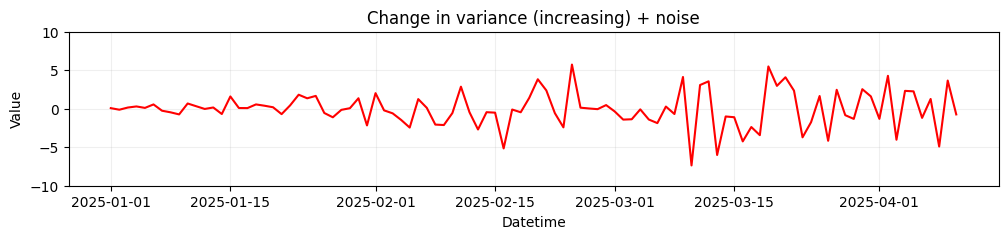

In [74]:
std_schedule = np.linspace(0.5, 20, n)
values = (0.1 * std_schedule) * eps

fig_size = (12.0, 2.0)
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(datetime_index, values, c="red")
ax.grid(alpha=0.2)
ax.set_xlabel("Datetime")
ax.set_ylabel("Value")
ax.set_ylim(-10, 10)
ax.set_title("Change in variance (increasing) + noise")
plt.show()

## Обьединение компонент

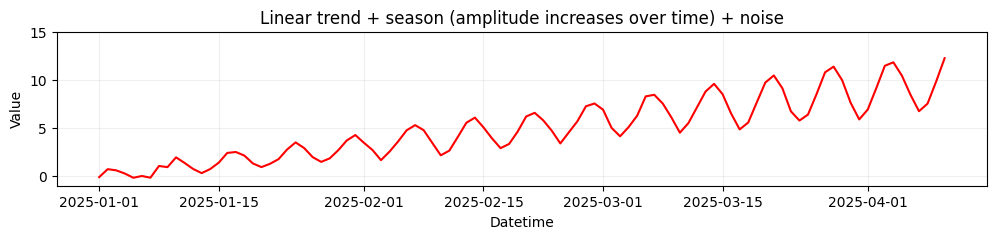

In [79]:
trend = 0.1 * t
# Amplitude of seasonal component increases over time
amplitude = np.linspace(0.5, 3.0, n)
seasonal = amplitude * np.sin(2 * np.pi * t / m)
values = trend + seasonal + 0.1 * eps

fig_size = (12.0, 2.0)
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(datetime_index, values, c="red")
ax.grid(alpha=0.2)
ax.set_xlabel("Datetime")
ax.set_ylabel("Value")
ax.set_ylim(-1, 15)
ax.set_title("Linear trend + season (amplitude increases over time) + noise")
plt.show()

## Более сложные формы нестационарности

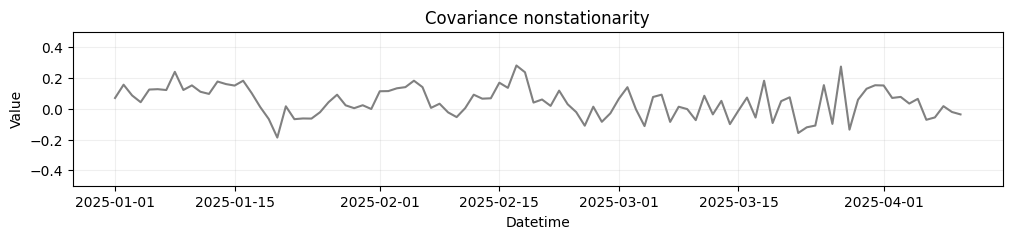

In [87]:
shift_point = n // 2
phi1, phi2 = 0.7, -0.3

# Choose innovation std so that the unconditional variance remains base_sigma^2
# For AR(1): Var(y) = sigma_e^2 / (1 - phi^2) => sigma_e = base_sigma * sqrt(1 - phi^2)
sigma_e1 = 0.1 * np.sqrt(1.0 - phi1 ** 2)
sigma_e2 = 0.1 * np.sqrt(1.0 - phi2 ** 2)

e1 = np.random.normal(0, sigma_e1, shift_point)
e2 = np.random.normal(0, sigma_e2, n - shift_point)

values = np.zeros(n)
values[0] = np.random.normal(0, 0.1)

# First regime
for i in range(1, shift_point):
    values[i] = phi1 * values[i - 1] + e1[i]

# Second regime
for i in range(shift_point, n):
    prev = values[i - 1] if i > 0 else 0.0
    values[i] = phi2 * prev + e2[i - shift_point]

fig_size = (12.0, 2.0)
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(datetime_index, values, c="grey")
ax.grid(alpha=0.2)
ax.set_xlabel("Datetime")
ax.set_ylabel("Value")
ax.set_ylim(-0.5, 0.5)
ax.set_title("Covariance nonstationarity")
plt.show()

## TODO: график автокорелляции и рассказ про то что иногда изменения на глаз заметить очень трудно

## Неочевидное разделение

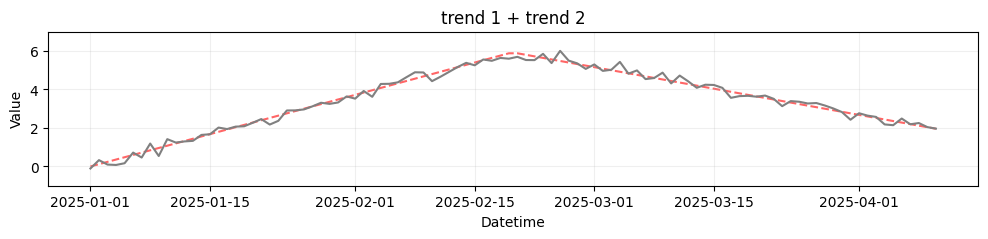

In [108]:
shift_point = n // 2
slope1, slope2 = 0.12, -0.08  # tweak as needed
trend = np.empty(n, dtype=float)
trend[:shift_point] = slope1 * np.arange(shift_point)
# Continue from the last level to avoid jumps at the kink
base_level = trend[shift_point - 1]
trend[shift_point:] = base_level + slope2 * np.arange(n - shift_point)
values = trend + 0.1 * eps

fig_size = (12.0, 2.0)
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(datetime_index, trend, '--', c="red", alpha=0.6, zorder=1)
ax.plot(datetime_index, values, c="grey", zorder=2)
ax.grid(alpha=0.2)
ax.set_xlabel("Datetime")
ax.set_ylabel("Value")
ax.set_ylim(-1, 7)
ax.set_title("trend 1 + trend 2")
plt.show()

## Комбинация различных компонентов (часть 2)

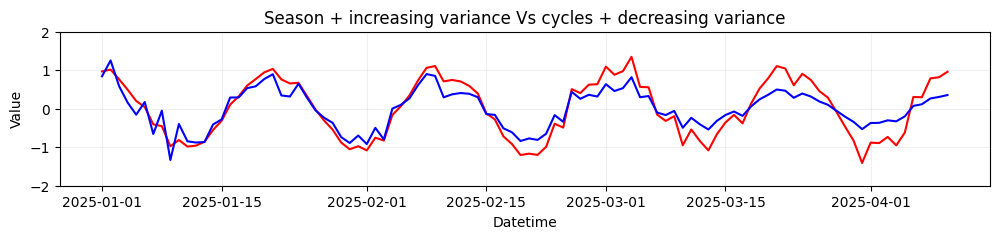

In [94]:
m_sync = 20  # common period for both series
phi = 0.0  # common phase
std_up = np.linspace(0.3, 1.5, n)  # increasing variance
seasonal = np.cos(2 * np.pi * t / m_sync + phi)  # SAME base wave as below
values_non_stationary_seasonal_var_increasing = seasonal + (0.1 * std_up) * eps

std_down = np.linspace(1.5, 0.3, n)  # decreasing variance
cycles = np.cos(2 * np.pi * t / m_sync + phi) * np.exp(-t / n)  # SAME wave + mild damping
values_stationary_cycles_var_decreasing = cycles + (0.1 * std_down) * eps

fig_size = (12.0, 2.0)
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(datetime_index, values_non_stationary_seasonal_var_increasing, c="red")
ax.plot(datetime_index, values_stationary_cycles_var_decreasing, c="blue")
ax.grid(alpha=0.2)
ax.set_xlabel("Datetime")
ax.set_ylabel("Value")
ax.set_ylim(-2, 2)
ax.set_title("Season + increasing variance Vs cycles + decreasing variance")
plt.show()

## TOOD завершить незаконченные разделы

1. Устранение тренда и других компонент 
2. Формальные тесты для обнаружения закономерностей
3. Прдварительная подготовка временных рядов - заполнение пропусков, сглаживание
4. Полезные визуализации по рядам
5. Генерация признаков (может тут имеет смысл сказать про lagged, агрегацию по окнам и так далее)